# Generalized Additive Models (GAMs) 
## About
Generalized Additive Models (GAMs) are smooth semi-parametric models of the form:

![alt tag](http://latex.codecogs.com/svg.latex?g\(\mathbb{E}\[y|X\]\)=\beta_0+f_1(X_1)+f_2(X_2)+\dots+f_p(X_p))

where `X.T = [X_1, X_2, ..., X_p]` are independent variables, `y` is the dependent variable, and `g()` is the link function that relates our predictor variables to the expected value of the dependent variable.

The feature functions `f_i()` are built using **penalized B splines**, which allow us to **automatically model non-linear relationships** without having to manually try out many different transformations on each variable.

<img src=https://raw.githubusercontent.com/dswah/pyGAM/master/imgs/pygam_basis.png>

GAMs extend generalized linear models by allowing non-linear functions of features while maintaining additivity. Since the model is additive, it is easy to examine the effect of each `X_i` on `Y` individually while holding all other predictors constant.

The result is a very flexible model, where it is easy to incorporate prior knowledge and control overfitting.



## pyGAM

Generalized Additive Models in Python.

<img src=https://github.com/dswah/pyGAM/raw/master/imgs/pygam_tensor.png>

## Documentation
- [Official pyGAM Documentation: Read the Docs](https://pygam.readthedocs.io/en/latest/?badge=latest)  
- [Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)  


## Installation
```pip install pygam```

### scikit-sparse
To speed up optimization on large models with constraints, it helps to have `scikit-sparse` installed because it contains a slightly faster, sparse version of Cholesky factorization. The import from `scikit-sparse` references `nose`, so you'll need that too.

The easiest way is to use Conda:  
```conda install -c conda-forge scikit-sparse nose```

[scikit-sparse docs](http://pythonhosted.org/scikit-sparse/overview.html#download)


## Build a linear GAM for regression

In [ ]:
## load required python packages
import pandas as pd
import numpy as np

! pip install pygam
from pygam import LinearGAM, LogisticGAM

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.4 MB/s eta 0:00:00


### Prepare the dataset


This dataset is about red variants of the Portuguese ‘Vinho Verde’ wine, available from the UCI machine learning repository. Input features are 11 physicochemical variables describe the red wine variants from various aspects. The target feature is the quality score, ranging from 0 to 10, that indicates how good the red wine is.


In [ ]:
redwine_url = 'https://raw.githubusercontent.com/ianshan0915/medium-articles/master/data/redwine-quality.csv'
redwine = pd.read_csv(redwine_url)

In [ ]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
redwine_X = redwine.drop(['quality'], axis=1).values
redwine_y = redwine['quality']

### Build the model via gridsearch

In [ ]:
lams = np.random.rand(100, 11)
lams = lams * 11 - 3
lams = np.exp(lams)
print(lams.shape)
gam = LinearGAM(n_splines=10).gridsearch(redwine_X, redwine_y, lam=lams)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

(100, 11)


100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


### Partial dependency plots

pyGAM supports partial dependence plot with matplotlib. The partial dependence for each term in a GAM can be visualized with a 95% confidence interval for the estimation function.


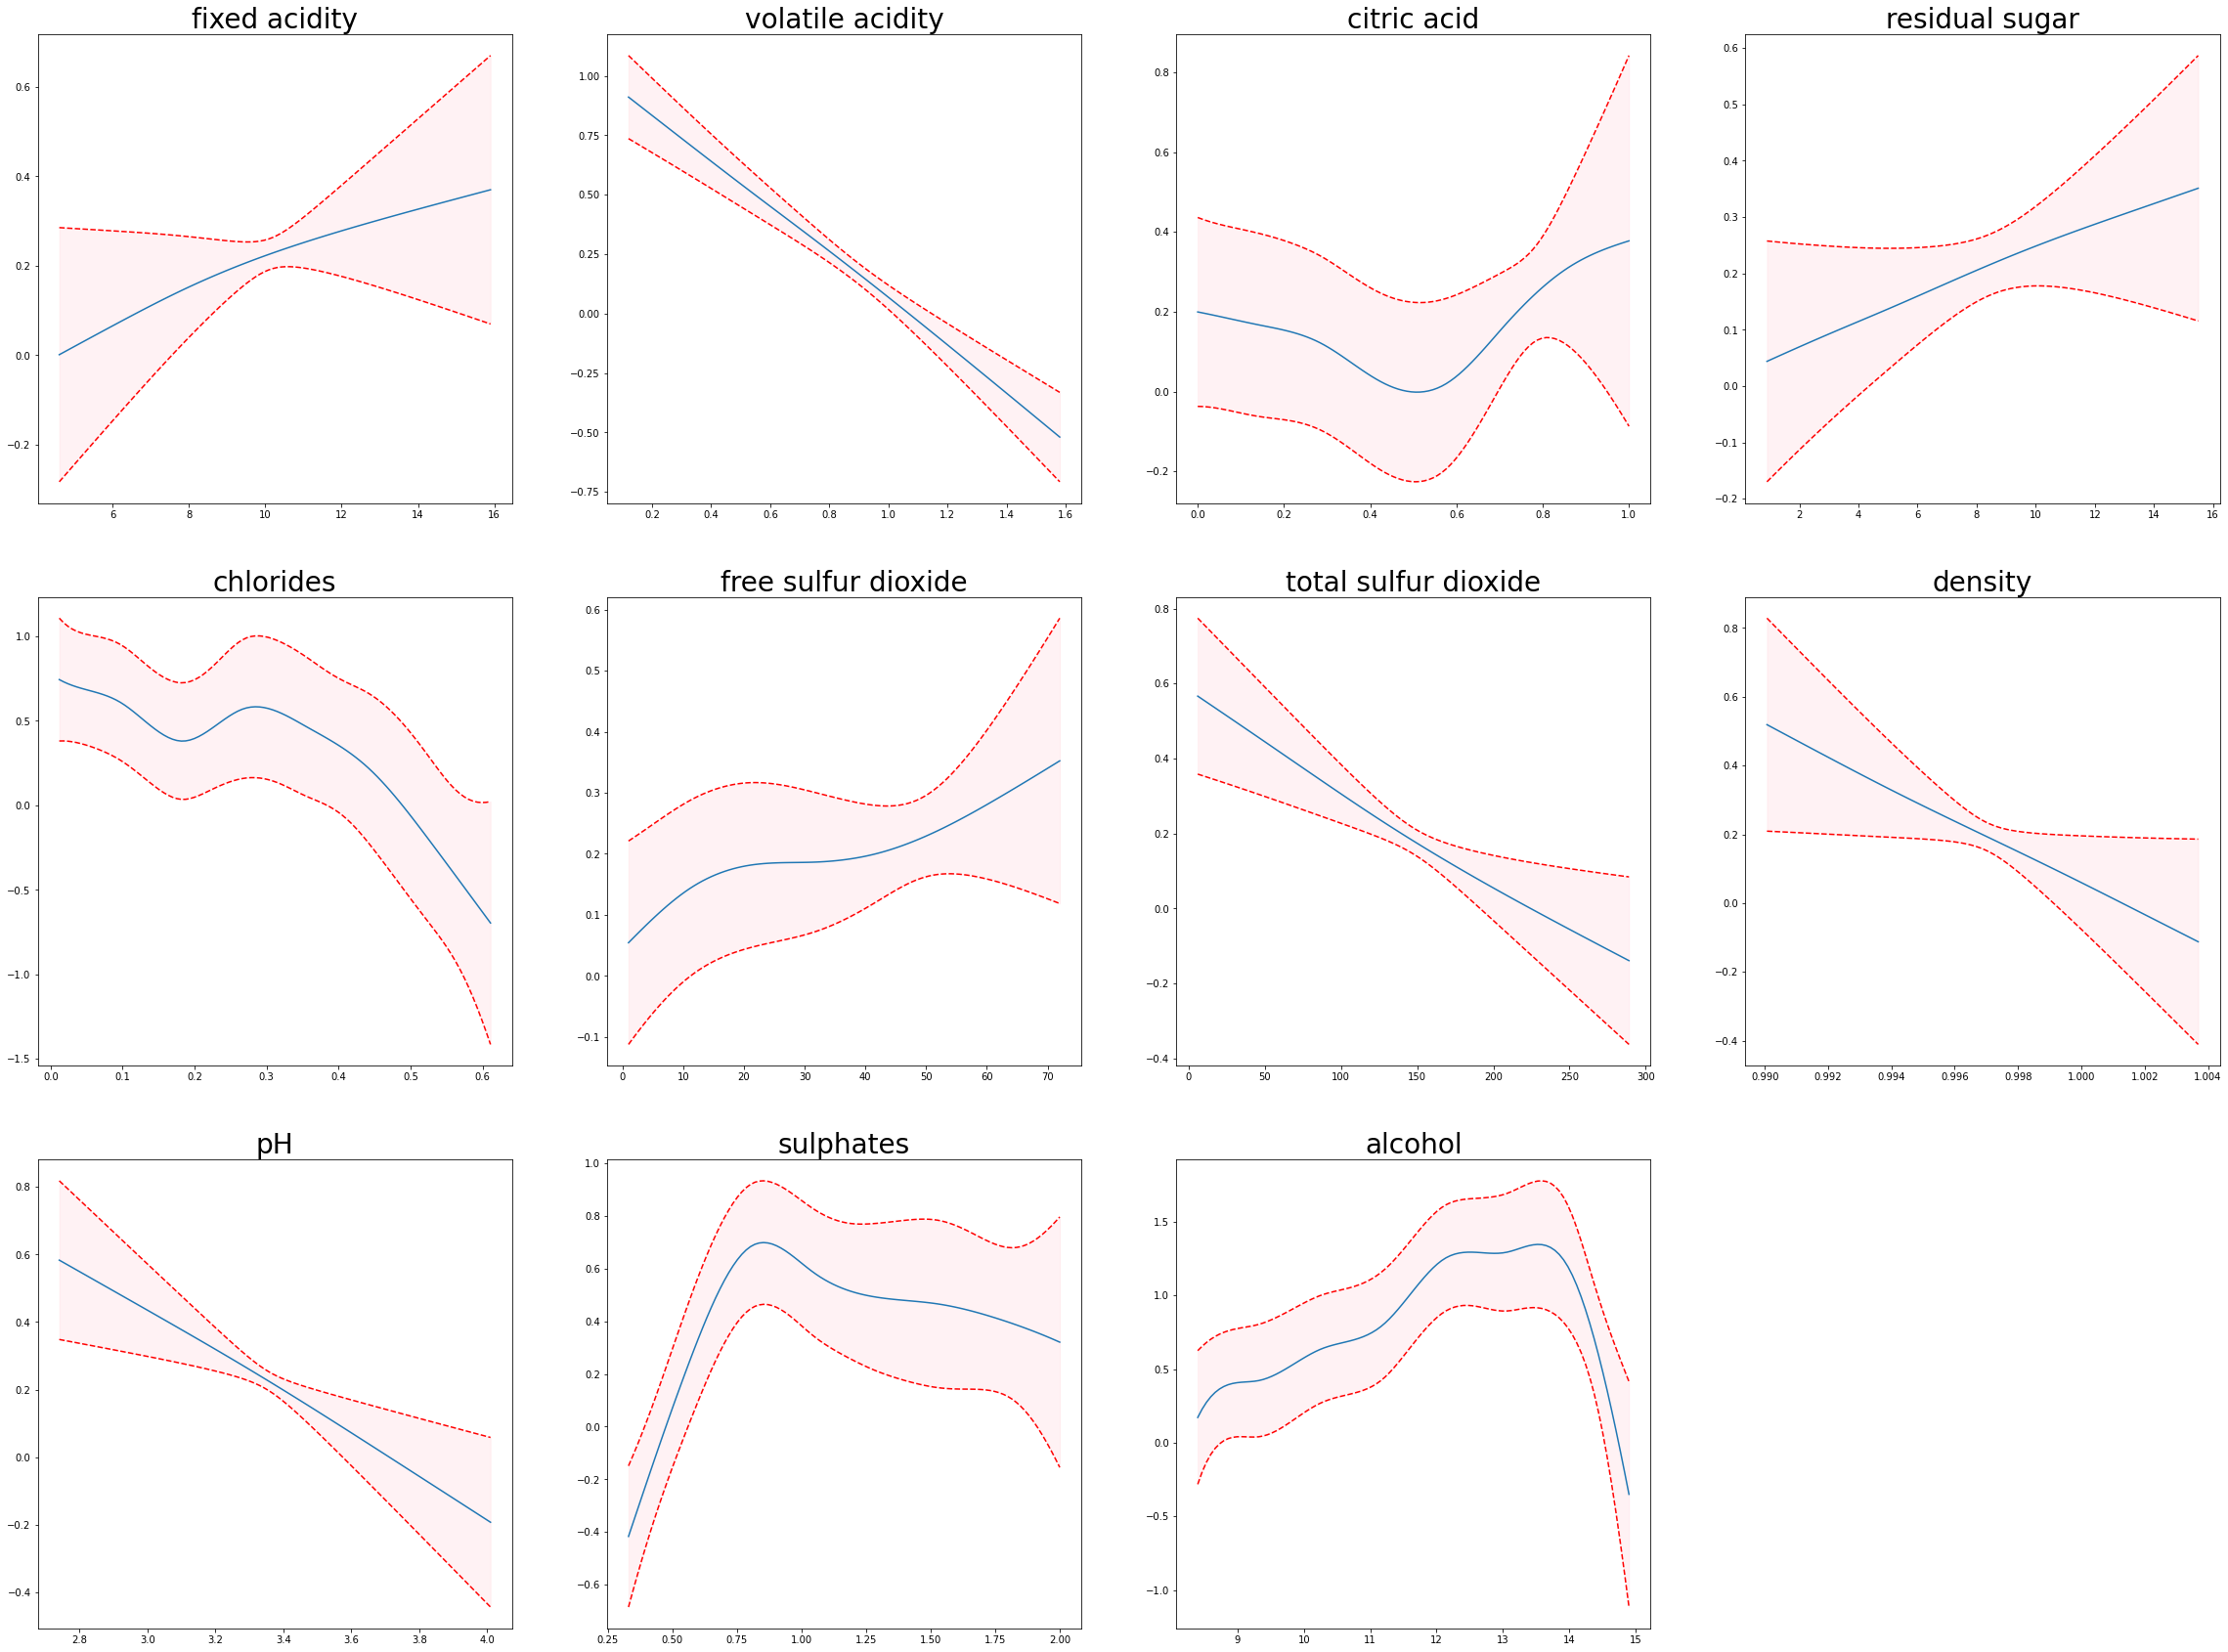

In [ ]:
num_rows=3
num_cols = 4

titles = redwine.columns[0:11]
fig = plt.figure(num=None, figsize=(num_cols * 10, num_rows * 10), 
                 facecolor='w', edgecolor='k')
fig.tight_layout(pad=7.0)
for i in range(len(titles)): 
    ax = plt.subplot(num_rows, num_cols, i + 1)
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i], fontsize=28)
    ax.fill_between(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1][:,0],
                  gam.partial_dependence(term=i, X=XX, width=.95)[1][:,1],
                  alpha=0.2, color = "pink")

So far, we have build a linear GAM that could predict the red wine quality score based on the physicochemical variables. More importantly, how each of these physicochemical variables affects the quality score is revealed in the above partial dependence plots. As shown above, volatile acidity, chlorides, total sulfur dioxide, density, and pH have a negative correlation with the quality score, meaning the higher value is, the lower the quality score is. On the other hand, the quality score increases as the values of residual sugar and free sulfur dioxide getting larger. We also notice that fixed acidity have litter influence on the quality score. The impacts of citric acid, sulphates, alcohol are more complex. For instance, the optimal alcohol level is around 13. Value higher or lower than that brings down the quality score.


## Build the model for classification

The data set contains 30 features that describe characteristics of the cell nuclei presented in the breast mass images. They are computed from 10 descriptors of a cell nucleus, including radius, texture, perimeter and etc.. Besides, each record is labeled as malignant (M) or bengn (B).



In [ ]:
tumors_url = 'https://raw.githubusercontent.com/ianshan0915/medium-articles/master/data/tumors.csv'
tumors = pd.read_csv(tumors_url)

In [ ]:
tumors.iloc[:,:11].head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809


###  Prepare the data set

In [ ]:
# drop the id column
tumors = tumors.drop(['id'],axis=1)

# encode the diagnosis column
tumors.loc[tumors['diagnosis']=='M','diagnosis'] =1
tumors.loc[tumors['diagnosis']=='B','diagnosis'] =0


tumors_X = tumors.iloc[:,:11].drop(['diagnosis'], axis=1).round(2).values
tumors_y = tumors['diagnosis']

### Build the model with LogisticGAM

In [ ]:
log_gam = LogisticGAM(n_splines=20).gridsearch(tumors_X, tumors_y)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.8/dist-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/dist-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.8/dist-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.8/dist-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.lin

did not converge


/usr/local/lib/python3.8/dist-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.8/dist-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/usr/local/lib/python3.8/dist-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
 18% (2 of 11) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:27/usr/local/lib/python3.8/dist-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.lin

In [ ]:
log_gam.accuracy(tumors_X, tumors_y)

0.9578207381370826

### Create the partial dependency plots to show interpretability

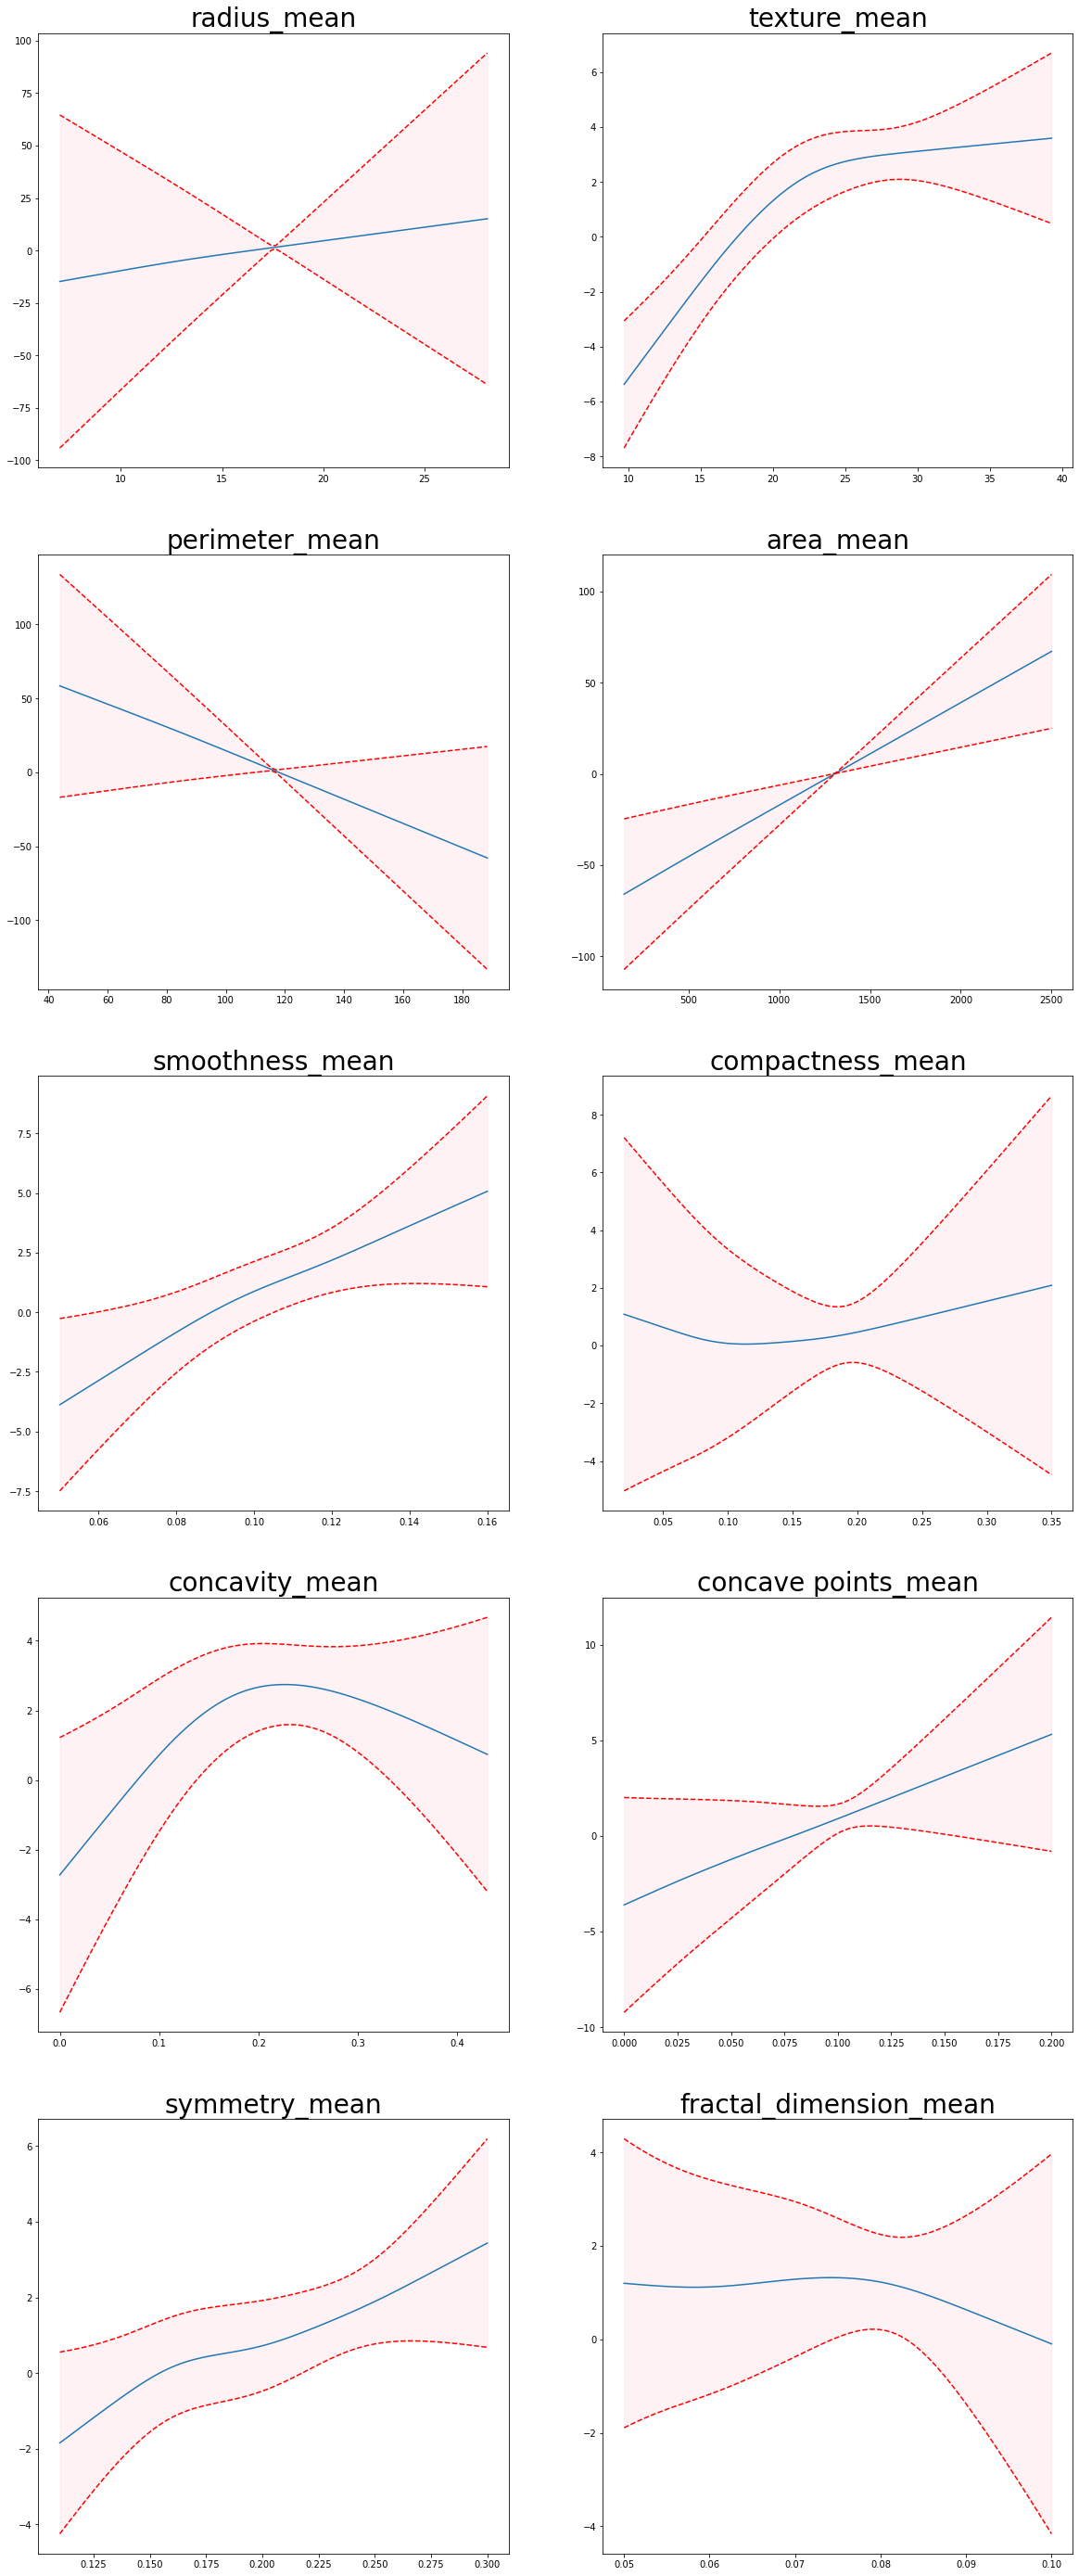

In [ ]:
num_rows=5
num_cols = 2
titles = tumors.columns[1:11] 
fig = plt.figure(num=None, figsize=(num_cols * 10, num_rows * 10), 
                 facecolor='w', edgecolor='k')
fig.tight_layout(pad=7.0)
for i in range(len(titles)): 
    ax = plt.subplot(num_rows, num_cols, i + 1)
    XX = log_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i], fontsize=28)
    ax.fill_between(XX[:, i], log_gam.partial_dependence(term=i, X=XX, width=.95)[1][:,0],
                  log_gam.partial_dependence(term=i, X=XX, width=.95)[1][:,1],
                  alpha=0.2, color = "pink")

The partial dependency plots uncover the interpretability of the GAM model. Variables that have positive correlation with the response variable include: mean radius, mean texture, mean area, mean smoothness, mean concave points, and mean symmetry. The higher value is, the more likely it is to be malignant. The higher mean perimeter means less likely it is to be malignant.


## Conclusion
As a data scientist, you should add GAM to your arsenal. Its advantage in interpretability could very useful in many scenarios. Hopefully, this article helps you know the technique and try it in your work.